In [1]:
# Importing libraries
using DataFrames
using LinearAlgebra
using Statistics
using Plots
using Random
using Measures
using GLM
import CSV

In [2]:
# Downloading and extract the dataset
X_file = "data_kPCA_2022-2023.txt"
y_file = "labels_kPCA_2022-2023.txt"
url = "https://raw.githubusercontent.com/alexdepremia/Unsupervised-Learning-Datasets/main/"

if !isfile(X_file)
    run(`wget $(url*X_file)`)
end
if !isfile(y_file)
    run(`wget $(url*y_file)`);
end

In [19]:
# Loading the dataset (X, y)
X = Matrix(DataFrame(CSV.File("data_kPCA_2022-2023.txt", delim=" ", header=false)))
y = parse.(Int8, readlines(open("labels_kPCA_2022-2023.txt")))

# Splitting train and test sets
train_prop = 0.8
n = length(y)
n_train = Int(round(train_prop*n))

X_train = X[begin:n_train, :]
X_test = X[n_train+1:end, :]
y_train = y[begin:n_train]
y_test = y[n_train+1:end]

n_test = length(y_test);

In [20]:
# Centering and rescaling features
mean = Statistics.mean(X_train, dims=1)
std = Statistics.std(X_train, dims=1)
X_train = (X_train.-mean)./std
X_test = (X_test.-mean)./std;

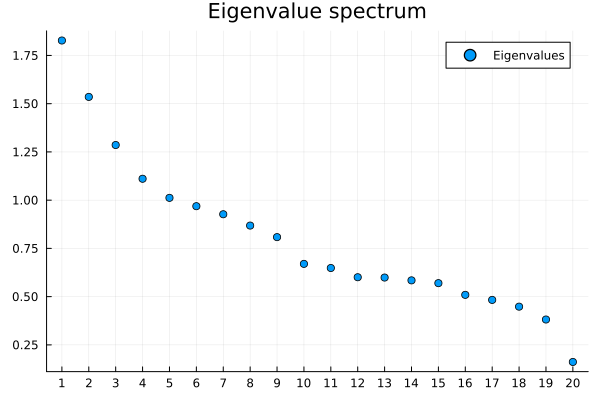

In [21]:
# Computing the covariance matrix
c = (transpose(X_train)*X_train)/n

# Computing eigenvalues and eigenvectors
eig = eigen(c)
eigenvectors = reverse(eig.vectors)
eigenvalues = reverse(eig.values);

# Plotting the eigenvalue spectrum
plot(eigenvalues,
    seriestype=:scatter,
    label="Eigenvalues",
    xticks=1:length(eigenvalues),
    #yscale=:log2,
    #yticks=[10.0^i for i in ceil(log10(maximum(eigenvalues))):-1:floor(log10(minimum(eigenvalues)))],
    title = "Eigenvalue spectrum")

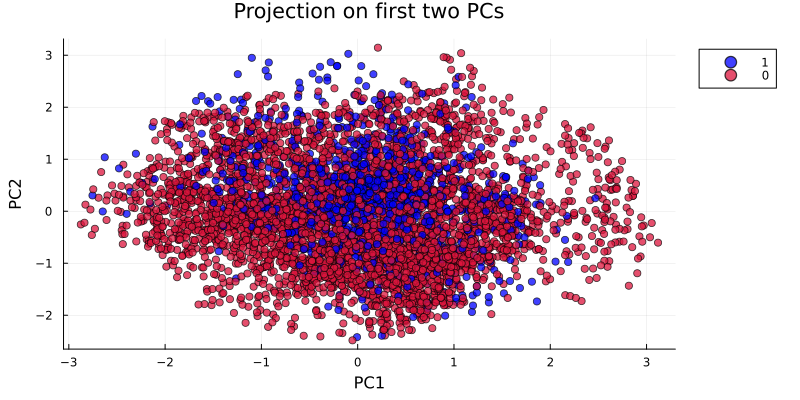

In [22]:
# Computing projection on principal components
pc_train = X_train*eigenvectors;

# Plotting data projected on first two principal components
distinguishable_colors = ("blue", "crimson")

classes = unique(y_train)
color_dict = Dict(c => distinguishable_colors[i] for (i,c) in enumerate(classes))
colors = map(class -> color_dict[class], y_train)

pc_plot = plot(
    pc_train[:, 1],
    pc_train[:, 2],
    color = colors,
    alpha=.75,
    xlabel="PC1",
    ylabel="PC2",
    seriestype=:scatter,
    title = "Projection on first two PCs",
    label=nothing
)


# The following is a trick done in order to show the legend
for class in classes
    indexes = (1:n_train)[y_train .== class]

    plot!(
        pc_train[indexes[1:2], 1],
        pc_train[indexes[1:2], 2],
        color=color_dict[class],
        label = string(class),
        seriestype=:scatter,
        alpha=0.75,
        legend = :outertopright)
end

plot!(size=(800, 400), margin = 4mm)

pc_plot


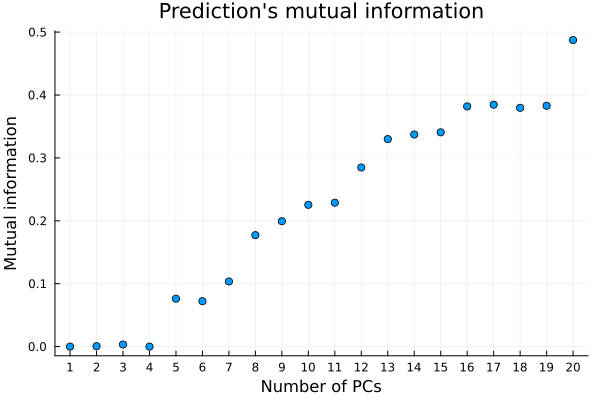

In [87]:
using FreqTables

# Logistic regression
function I(a, b)
    p = freqtable(DataFrame(a = a, b = b), :a, :b) / length(a)
    n_classes_a = length(unique(a))
    n_classes_b = length(unique(b))
    sum([p[i,j]>0. ? p[i,j]*log(p[i,j]/(sum(p[i,:])*sum(p[:,j]))) : 0 for i=1:n_classes_a, j=1:n_classes_b])
end

function accuracy(a, b)
    p = freqtable(DataFrame(a = a, b = b), :a, :b) / length(a)
    n_classes_a = length(unique(a))
    n_classes_b = length(unique(b))
    sum([p[i, i] for i=1:n_classes_b])
end

# Getting test set projection on PCs
pc_test = X_test*eigenvectors;

pc_limit = 20
mi = zeros(pc_limit)
acc = zeros(pc_limit)

for i in 1:pc_limit

    x_train = hcat(ones(size(pc_train)[1]), pc_train[:,begin:i]) # I have to add the bias manually...
    x_test = hcat(ones(size(pc_test)[1]), pc_test[:,begin:i])
    model = glm(x_train, y_train, Bernoulli())
    y_predicted = predict(model, x_test).>0.5
    mi[i] = I(y_test, y_predicted)
    acc[i] = accuracy(y_test, y_predicted)
end

plot(mi,
    seriestype=:scatter,
    #label="Mutual information",
    label=nothing,
    xticks=1:length(eigenvalues),
    xlabel = "Number of PCs",
    ylabel = "Mutual information",
    title = "Prediction's mutual information")

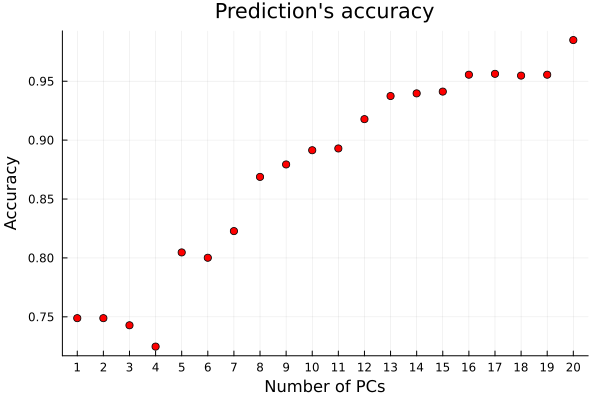

In [88]:
plot(acc,
seriestype=:scatter,
#label="Mutual information",
label=nothing,
color= :red,
xticks=1:length(eigenvalues),
xlabel = "Number of PCs",
ylabel = "Accuracy",
title = "Prediction's accuracy")

In [5]:
# Computing the Kernel matrix
kernel(a,b) = exp(-0.5*sum((a-b).^2))
K = [kernel(X_train[i,:], X_train[j,:]) for i=1:n_train, j=1:n_train];

In [ ]:
# Get Gram matrix by double Centering
G = 

In [7]:
# Computing eigenvalues and eigenvectors
eig = eigen(G)
eigenvectors = reverse(eig.vectors)
eigenvalues = reverse(eig.values);

In [ ]:
# Plotting the eigenvalue spectrum
plot(eigenvalues,
    seriestype=:scatter,
    label="Eigenvalues",
    xticks=1:length(eigenvalues),
    yscale=:log10,
    yticks=[10.0^i for i in ceil(log10(maximum(eigenvalues))):-1:floor(log10(minimum(eigenvalues)))],
    title = "Eigenvalue spectrum")

In [ ]:
# Computing projection on principal components
pc = m_standardized*eigenvectors;

In [ ]:
# Plotting data projected on first two principal components
distinguishable_colors = ("blue", "crimson", "green", "gray", "purple", "orange", "cyan")

classes = unique(df.Class)
color_dict = Dict(c => distinguishable_colors[i] for (i,c) in enumerate(classes))
colors = map(class -> color_dict[class], df.Class)

pc_plot = plot(
    pc[:, 1],
    pc[:, 2],
    color = colors,
    alpha=.75,
    xlabel="PC1",
    ylabel="PC2",
    seriestype=:scatter,
    title = "Projection on first two PCs",
    label=nothing
)


# The following is a trick done in order to show the legend
for class in classes
    indexes = (1:n)[df.Class .== class]

    plot!(
        pc[indexes[1:2], 1],
        pc[indexes[1:2], 2],
        color=color_dict[class],
        label = class,
        seriestype=:scatter,
        alpha=0.75,
        legend = :outertopright)
end

plot!(size=(800, 400), margin = 4mm)

pc_plot

In [ ]:
# Plotting data projected on first three principal components
distinguishable_colors = ("blue", "crimson", "green", "gray", "purple", "orange", "cyan")

classes = unique(df.Class)
color_dict = Dict(c => distinguishable_colors[i] for (i,c) in enumerate(classes))
colors = map(class -> color_dict[class], df.Class)

pc_plot = plot(
    pc[:, 1],
    pc[:, 2],
    pc[:, 3],
    color = colors,
    alpha=.75,
    xlabel="PC1",
    ylabel="PC2",
    zlabel="PC3",
    seriestype=:scatter,
    title = "Projection on first three PCs",
    label=nothing
)


# The following is a trick done in order to show the legend
for class in classes
    indexes = (1:n)[df.Class .== class]

    plot!(
        pc[indexes[1:2], 1],
        pc[indexes[1:2], 2],
        pc[indexes[1:2], 3],
        color=color_dict[class],
        label = class,
        seriestype=:scatter,
        alpha=0.75,
        legend = :outertopright)
end

pc_plot

In [ ]:
# Saving an interactive 3d plot of the projection on the first three PCs (html) 

import PlotlyJS

plot_df = DataFrame(PC1=pc[:, 1], PC2=pc[:, 2], PC3=pc[:, 3], class=df.Class, color=colors)

pca_plot = PlotlyJS.plot(
    plot_df,
    x = :PC1,
    y = :PC2,
    z = :PC3,
    type = "scatter3d",
    labels=Dict(
        :PC1 => "PC1",
        :PC2 => "PC2",
        :PC3 => "PC3"
    ),
    color = :class,
    mode="markers",
    marker_size=1.5
)

open("./dry_beans_3d_pcs_plot.html", "w") do io
    PlotlyJS.PlotlyBase.to_html(io, pca_plot.plot)
end